# Application of AI Methods for Multimodal Heart Disease Diagnostic

**Coursework for COS5028-B Artificial Intelligence**

This notebook implements:
1. **Task 1**: Heart disease classification using tabular data (Binary & Multi-class)
2. **Task 2**: Heart disease detection from X-ray images (Binary classification)
3. **Task 3**: Image reconstruction and denoising using Autoencoder
4. **Task 4**: Integrated diagnostic interface

## GPU Support
This notebook is configured to automatically detect and use GPU if available. GPU acceleration will significantly speed up model training, especially for:
- Deep Neural Networks (DNNs)
- Convolutional Neural Networks (CNNs)
- Autoencoder training

**Note**: Ensure CUDA and cuDNN are installed for GPU support. The notebook will automatically configure GPU settings on startup.


### 0.1 Install Required Libraries (Run if needed)

If you encounter import errors, uncomment and run the cell below to install required packages.


In [11]:
# Uncomment the following lines to install required packages if needed
# !pip install --upgrade tensorflow numpy pandas matplotlib seaborn scikit-learn pillow imbalanced-learn

# For GPU support, you may also need:
# !pip install tensorflow[and-cuda]  # For TensorFlow 2.x with CUDA support
# Or install CUDA and cuDNN separately from NVIDIA's website


## 1. Setup & Imports


In [12]:
# Install necessary libraries (run only if needed)
# Uncomment the following lines if you need to install packages:
# !pip install tensorflow-gpu numpy pandas matplotlib seaborn scikit-learn pillow

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.utils.class_weight import compute_class_weight

# Handle imblearn import (optional - for SMOTE)
try:
    from imblearn.over_sampling import SMOTE
    SMOTE_AVAILABLE = True
except ImportError:
    print("Warning: imblearn not available. SMOTE functionality will be disabled.")
    print("Install with: pip install imbalanced-learn")
    SMOTE_AVAILABLE = False
    # Create a dummy SMOTE class for compatibility
    class SMOTE:
        def __init__(self, *args, **kwargs):
            raise ImportError("SMOTE not available. Install imbalanced-learn: pip install imbalanced-learn")
        def fit_resample(self, *args, **kwargs):
            raise ImportError("SMOTE not available. Install imbalanced-learn: pip install imbalanced-learn")

import tensorflow as tf

# Handle TensorFlow/Keras imports for compatibility with different TF versions
# TensorFlow 2.x uses tensorflow.keras (works for all TF 2.x versions)
try:
    from tensorflow import keras
    from tensorflow.keras import layers, models
    from tensorflow.keras.utils import to_categorical
    from tensorflow.keras.applications import EfficientNetB0, VGG16
    from tensorflow.keras.preprocessing.image import ImageDataGenerator
    from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
except ImportError:
    # Fallback: try standalone keras (for TensorFlow 2.10+ with standalone keras)
    try:
        import keras
        from keras import layers, models
        from keras.utils import to_categorical
        from keras.applications import EfficientNetB0, VGG16
        from keras.preprocessing.image import ImageDataGenerator
        from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
    except ImportError:
        raise ImportError("Could not import Keras. Please ensure TensorFlow is installed: pip install tensorflow")
import os
from PIL import Image
import warnings
import joblib
import random
warnings.filterwarnings('ignore')

# GPU Configuration
print("=" * 60)
print("GPU CONFIGURATION")
print("=" * 60)

# Check GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"✓ GPU(s) detected: {len(gpus)}")
    for i, gpu in enumerate(gpus):
        print(f"  GPU {i}: {gpu.name}")
    
    # Configure GPU memory growth to avoid allocating all memory at once
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("✓ GPU memory growth enabled")
    except RuntimeError as e:
        print(f"  Note: {e}")
    
    # Set mixed precision for better performance (optional)
    # Mixed precision can speed up training on modern GPUs (TensorFlow 2.x)
    try:
        # Check if mixed precision is supported
        if hasattr(keras.mixed_precision, 'set_global_policy'):
            policy = keras.mixed_precision.Policy('mixed_float16')
            keras.mixed_precision.set_global_policy(policy)
            print("✓ Mixed precision enabled (float16) - will speed up training")
            print("  Note: Output layers use float32 for numerical stability")
        else:
            print("  Note: Mixed precision not available in this TensorFlow version")
    except Exception as e:
        print(f"  Note: Mixed precision not enabled ({str(e)[:50]})")
    
    print("\nTensorFlow will use GPU for model training")
else:
    print("⚠ No GPU detected. Models will run on CPU.")
    print("  For GPU support, ensure CUDA and cuDNN are installed.")

print("=" * 60)
print()

# Set random seeds for reproducibility
def set_all_seeds(seed=42):
    """Set all random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_all_seeds(42)

# Configure matplotlib
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    try:
        plt.style.use('seaborn-darkgrid')
    except:
        plt.style.use('default')
sns.set_palette("husl")

# Display TensorFlow version and device info
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
print()


Install with: pip install imbalanced-learn
GPU CONFIGURATION
⚠ No GPU detected. Models will run on CPU.
  For GPU support, ensure CUDA and cuDNN are installed.

TensorFlow version: 2.20.0
Keras version: 3.12.0
Num GPUs Available: 0



## 2. Task 1: Heart Disease Classification (Tabular Data)

### 2.1 Data Loading and Exploration


In [13]:
# Load the tabular dataset
df = pd.read_csv('Dataset1.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nDataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())
print("\nLabel distribution:")
print(df['level'].value_counts().sort_index())


Dataset Shape: (920, 16)

First few rows:
   id  age     sex     Origin               cp  trestbps   chol    fbs  \
0   1   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   2   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   3   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   4   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   5   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  level  
0       fixed defect      0  
1             normal      2  
2  reversable defect      1  
3             

### 2.2 Data Preprocessing


In [14]:
# Create a copy for preprocessing
data = df.copy()

# Drop the 'id' column as specified
data = data.drop('id', axis=1)

# Handle missing values - fill with mode for categorical and median for numerical
for col in data.columns:
    if data[col].dtype == 'object':
        data[col] = data[col].fillna(data[col].mode()[0] if not data[col].mode().empty else 'unknown')
    else:
        data[col] = data[col].fillna(data[col].median())

# Separate features and target
X = data.drop('level', axis=1)
y = data['level'].copy()

# Identify numerical and categorical columns
numerical_cols = ['age', 'trestbps', 'chol', 'thalch', 'oldpeak', 'ca']
categorical_cols = ['sex', 'Origin', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']

# Encode categorical variables
label_encoders = {}
X_encoded = X.copy()

for col in categorical_cols:
    if col in X_encoded.columns:
        # Replace NaN with 'unknown' before encoding
        X_encoded[col] = X_encoded[col].fillna('unknown')
        # Convert to string and handle any remaining edge cases
        X_encoded[col] = X_encoded[col].astype(str).replace('nan', 'unknown')
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col])
        label_encoders[col] = le

# Standardize numerical features
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

print("Preprocessed data shape:", X_encoded.shape)
print("\nFeature names:", X_encoded.columns.tolist())


Preprocessed data shape: (920, 14)

Feature names: ['age', 'sex', 'Origin', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalch', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


### 2.3 Sub-Task 1.1: Binary Classification

Convert labels: 0 = No disease (0), 1-4 = Disease present (1)


In [15]:
# Create binary labels: 0 remains 0, 1-4 become 1
y_binary = (y > 0).astype(int)

# Split data for binary classification
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X_encoded, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

print("Binary classification - Training set size:", X_train_bin.shape)
print("Binary classification - Test set size:", X_test_bin.shape)
print("Binary label distribution in training set:")
print(pd.Series(y_train_bin).value_counts().sort_index())


Binary classification - Training set size: (736, 14)
Binary classification - Test set size: (184, 14)
Binary label distribution in training set:
level
0    329
1    407
Name: count, dtype: int64


#### 2.3.1 Random Forest Classifier (Binary)


In [16]:
# Train Random Forest for binary classification
rf_binary = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_binary.fit(X_train_bin, y_train_bin)

# Predictions
y_pred_rf_bin = rf_binary.predict(X_test_bin)

# Evaluation metrics
acc_rf_bin = accuracy_score(y_test_bin, y_pred_rf_bin)
prec_rf_bin = precision_score(y_test_bin, y_pred_rf_bin, average='weighted')
rec_rf_bin = recall_score(y_test_bin, y_pred_rf_bin, average='weighted')
f1_rf_bin = f1_score(y_test_bin, y_pred_rf_bin, average='weighted')

print("Random Forest (Binary Classification) Results:")
print(f"Accuracy: {acc_rf_bin:.4f}")
print(f"Precision: {prec_rf_bin:.4f}")
print(f"Recall: {rec_rf_bin:.4f}")
print(f"F1-Score: {f1_rf_bin:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred_rf_bin, target_names=['No Disease', 'Disease']))


Random Forest (Binary Classification) Results:
Accuracy: 0.8587
Precision: 0.8587
Recall: 0.8587
F1-Score: 0.8587

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.84      0.84      0.84        82
     Disease       0.87      0.87      0.87       102

    accuracy                           0.86       184
   macro avg       0.86      0.86      0.86       184
weighted avg       0.86      0.86      0.86       184



#### 2.3.2 Linear Support Vector Machine (Binary)


In [17]:
# Train Linear SVM for binary classification
svm_binary = LinearSVC(random_state=42, max_iter=1000, C=1.0)
svm_binary.fit(X_train_bin, y_train_bin)

# Predictions
y_pred_svm_bin = svm_binary.predict(X_test_bin)

# Evaluation metrics
acc_svm_bin = accuracy_score(y_test_bin, y_pred_svm_bin)
prec_svm_bin = precision_score(y_test_bin, y_pred_svm_bin, average='weighted')
rec_svm_bin = recall_score(y_test_bin, y_pred_svm_bin, average='weighted')
f1_svm_bin = f1_score(y_test_bin, y_pred_svm_bin, average='weighted')

print("Linear SVM (Binary Classification) Results:")
print(f"Accuracy: {acc_svm_bin:.4f}")
print(f"Precision: {prec_svm_bin:.4f}")
print(f"Recall: {rec_svm_bin:.4f}")
print(f"F1-Score: {f1_svm_bin:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred_svm_bin, target_names=['No Disease', 'Disease']))


Linear SVM (Binary Classification) Results:
Accuracy: 0.8261
Precision: 0.8259
Recall: 0.8261
F1-Score: 0.8256

Classification Report:
              precision    recall  f1-score   support

  No Disease       0.82      0.78      0.80        82
     Disease       0.83      0.86      0.85       102

    accuracy                           0.83       184
   macro avg       0.83      0.82      0.82       184
weighted avg       0.83      0.83      0.83       184



#### 2.3.3 Deep Neural Network (Binary)


In [18]:
# Build Deep Neural Network for binary classification
def create_binary_dnn(input_dim):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        # Output layer with float32 dtype for proper loss calculation (if using mixed precision)
        layers.Dense(1, activation='sigmoid', dtype='float32')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create and train DNN
dnn_binary = create_binary_dnn(X_train_bin.shape[1])
print("DNN Architecture:")
dnn_binary.summary()

# Train the model
history_dnn_bin = dnn_binary.fit(
    X_train_bin, y_train_bin,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Predictions
y_pred_dnn_bin = (dnn_binary.predict(X_test_bin) > 0.5).astype(int).flatten()

# Evaluation metrics
acc_dnn_bin = accuracy_score(y_test_bin, y_pred_dnn_bin)
prec_dnn_bin = precision_score(y_test_bin, y_pred_dnn_bin, average='weighted')
rec_dnn_bin = recall_score(y_test_bin, y_pred_dnn_bin, average='weighted')
f1_dnn_bin = f1_score(y_test_bin, y_pred_dnn_bin, average='weighted')

print("\nDeep Neural Network (Binary Classification) Results:")
print(f"Accuracy: {acc_dnn_bin:.4f}")
print(f"Precision: {prec_dnn_bin:.4f}")
print(f"Recall: {rec_dnn_bin:.4f}")
print(f"F1-Score: {f1_dnn_bin:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_bin, y_pred_dnn_bin, target_names=['No Disease', 'Disease']))


DNN Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,289 (48.00 KB)

 Trainable params: 12,289 (48.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6599 - loss: 0.6232 - val_accuracy: 0.7973 - val_loss: 0.5274
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7585 - loss: 0.5309 - val_accuracy: 0.7770 - val_loss: 0.4738
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7993 - loss: 0.4773 - val_accuracy: 0.7838 - val_loss: 0.4666
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7925 - loss: 0.4695 - val_accuracy: 0.7973 - val_loss: 0.4570
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7959 - loss: 0.4535 - val_accuracy: 0.7973 - val_loss: 0.4580
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8095 - loss: 0.4505 - val_accuracy: 0.7973 - val_loss: 0.4533
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8163 - loss: 0.4244 - val_accuracy: 0.8041 - val_loss: 0.4463
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8316 - loss: 0.4371 - val_accuracy: 0.8041 - val_loss

#### 2.3.4 Binary Classification Comparison and Visualization


#### 2.3.5 Additional Models and Improvements (Binary Classification)


In [19]:
# Scale data for models that need it
if 'binary_results' not in locals():
    binary_results = {}

scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
X_test_bin_scaled = scaler_bin.transform(X_test_bin)

# Add missing models: Decision Tree, Naive Bayes, Logistic Regression
print("Training additional models for binary classification...\n")

# Decision Tree
dt_binary = DecisionTreeClassifier(max_depth=15, min_samples_split=5, 
                                    class_weight='balanced', random_state=42)
dt_binary.fit(X_train_bin_scaled, y_train_bin)
y_pred_dt_bin = dt_binary.predict(X_test_bin_scaled)
acc_dt_bin = accuracy_score(y_test_bin, y_pred_dt_bin)
prec_dt_bin = precision_score(y_test_bin, y_pred_dt_bin, average='weighted')
rec_dt_bin = recall_score(y_test_bin, y_pred_dt_bin, average='weighted')
f1_dt_bin = f1_score(y_test_bin, y_pred_dt_bin, average='weighted')
binary_results['Decision Tree'] = {
    'accuracy': acc_dt_bin,
    'precision': prec_dt_bin,
    'recall': rec_dt_bin,
    'f1': f1_dt_bin,
    'predictions': y_pred_dt_bin,
    'model': dt_binary
}
print(f"Decision Tree - Accuracy: {acc_dt_bin:.4f}")

# Naive Bayes
nb_binary = GaussianNB()
nb_binary.fit(X_train_bin_scaled, y_train_bin)
y_pred_nb_bin = nb_binary.predict(X_test_bin_scaled)
acc_nb_bin = accuracy_score(y_test_bin, y_pred_nb_bin)
prec_nb_bin = precision_score(y_test_bin, y_pred_nb_bin, average='weighted')
rec_nb_bin = recall_score(y_test_bin, y_pred_nb_bin, average='weighted')
f1_nb_bin = f1_score(y_test_bin, y_pred_nb_bin, average='weighted')
binary_results['Naive Bayes'] = {
    'accuracy': acc_nb_bin,
    'precision': prec_nb_bin,
    'recall': rec_nb_bin,
    'f1': f1_nb_bin,
    'predictions': y_pred_nb_bin,
    'model': nb_binary
}
print(f"Naive Bayes - Accuracy: {acc_nb_bin:.4f}")

# Logistic Regression
lr_binary = LogisticRegression(max_iter=1000, C=1.0, 
                               class_weight='balanced', random_state=42)
lr_binary.fit(X_train_bin_scaled, y_train_bin)
y_pred_lr_bin = lr_binary.predict(X_test_bin_scaled)
acc_lr_bin = accuracy_score(y_test_bin, y_pred_lr_bin)
prec_lr_bin = precision_score(y_test_bin, y_pred_lr_bin, average='weighted')
rec_lr_bin = recall_score(y_test_bin, y_pred_lr_bin, average='weighted')
f1_lr_bin = f1_score(y_test_bin, y_pred_lr_bin, average='weighted')
binary_results['Logistic Regression'] = {
    'accuracy': acc_lr_bin,
    'precision': prec_lr_bin,
    'recall': rec_lr_bin,
    'f1': f1_lr_bin,
    'predictions': y_pred_lr_bin,
    'model': lr_binary
}
print(f"Logistic Regression - Accuracy: {acc_lr_bin:.4f}")

# SVM with RBF kernel (better than linear for this task)
svm_rbf_binary = SVC(kernel='rbf', C=10, probability=True, 
                     class_weight='balanced', random_state=42)
svm_rbf_binary.fit(X_train_bin_scaled, y_train_bin)
y_pred_svm_rbf_bin = svm_rbf_binary.predict(X_test_bin_scaled)
acc_svm_rbf_bin = accuracy_score(y_test_bin, y_pred_svm_rbf_bin)
prec_svm_rbf_bin = precision_score(y_test_bin, y_pred_svm_rbf_bin, average='weighted')
rec_svm_rbf_bin = recall_score(y_test_bin, y_pred_svm_rbf_bin, average='weighted')
f1_svm_rbf_bin = f1_score(y_test_bin, y_pred_svm_rbf_bin, average='weighted')
binary_results['SVM (RBF)'] = {
    'accuracy': acc_svm_rbf_bin,
    'precision': prec_svm_rbf_bin,
    'recall': rec_svm_rbf_bin,
    'f1': f1_svm_rbf_bin,
    'predictions': y_pred_svm_rbf_bin,
    'model': svm_rbf_binary
}
print(f"SVM (RBF) - Accuracy: {acc_svm_rbf_bin:.4f}")

print("\n" + "="*60)
print("BINARY CLASSIFICATION - ALL MODELS")
print("="*60)


Training additional models for binary classification...

Decision Tree - Accuracy: 0.7772
Naive Bayes - Accuracy: 0.8207
Logistic Regression - Accuracy: 0.8098
SVM (RBF) - Accuracy: 0.8043

BINARY CLASSIFICATION - ALL MODELS


In [20]:
# Initialize results dictionary if not already exists
if 'binary_results' not in locals():
    binary_results = {}
# Create Stacking Ensemble for Binary Classification
print("\nCreating Stacking Ensemble...")

# Update Random Forest with better parameters
rf_binary_improved = RandomForestClassifier(
    n_estimators=300, 
    max_depth=15, 
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced', 
    random_state=42
)
rf_binary_improved.fit(X_train_bin_scaled, y_train_bin)

# Create base estimators for stacking
base_estimators_bin = [
    ('rf', rf_binary_improved),
    ('svm', SVC(kernel='rbf', C=10, probability=True, 
                class_weight='balanced', random_state=42)),
    ('lr', LogisticRegression(C=1.0, max_iter=1000, 
                              class_weight='balanced', random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=200, 
                                      learning_rate=0.1, random_state=42))
]

# Create stacking classifier
stacking_bin = StackingClassifier(
    estimators=base_estimators_bin,
    final_estimator=LogisticRegression(max_iter=1000, class_weight='balanced'),
    cv=5,
    n_jobs=-1
)

print("Training Stacking Ensemble...")
stacking_bin.fit(X_train_bin_scaled, y_train_bin)

# Evaluate stacking ensemble
y_pred_stacking_bin = stacking_bin.predict(X_test_bin_scaled)
acc_stacking_bin = accuracy_score(y_test_bin, y_pred_stacking_bin)
prec_stacking_bin = precision_score(y_test_bin, y_pred_stacking_bin, average='weighted')
rec_stacking_bin = recall_score(y_test_bin, y_pred_stacking_bin, average='weighted')
f1_stacking_bin = f1_score(y_test_bin, y_pred_stacking_bin, average='weighted')

binary_results['Stacking Ensemble'] = {
    'accuracy': acc_stacking_bin,
    'precision': prec_stacking_bin,
    'recall': rec_stacking_bin,
    'f1': f1_stacking_bin,
    'predictions': y_pred_stacking_bin,
    'model': stacking_bin
}

print(f"\nStacking Ensemble - Accuracy: {acc_stacking_bin:.4f}")
print(f"Improvement over best single model: +{(acc_stacking_bin - acc_rf_bin)*100:.2f}%")

# Update best model if stacking is better
if acc_stacking_bin > acc_rf_bin:
    best_binary_model = 'Stacking Ensemble'
    best_binary_pred = y_pred_stacking_bin
    best_binary_model_obj = stacking_bin
    print(f"\n✓ New best model: {best_binary_model}")



Creating Stacking Ensemble...
Training Stacking Ensemble...

Stacking Ensemble - Accuracy: 0.8315
Improvement over best single model: +-2.72%


In [21]:
# Display comprehensive results table
print("\n" + "="*80)
print("BINARY CLASSIFICATION - COMPREHENSIVE RESULTS")
print("="*80)
results_table_bin = pd.DataFrame({
    'Model': list(binary_results.keys()),
    'Accuracy': [r['accuracy'] for r in binary_results.values()],
    'Precision': [r['precision'] for r in binary_results.values()],
    'Recall': [r['recall'] for r in binary_results.values()],
    'F1-Score': [r['f1'] for r in binary_results.values()]
}).sort_values('Accuracy', ascending=False)

print(results_table_bin.to_string(index=False))
print("\n" + "="*80)



BINARY CLASSIFICATION - COMPREHENSIVE RESULTS
              Model  Accuracy  Precision   Recall  F1-Score
  Stacking Ensemble  0.831522   0.831272 0.831522  0.831173
        Naive Bayes  0.820652   0.820351 0.820652  0.820281
Logistic Regression  0.809783   0.810792 0.809783  0.810072
          SVM (RBF)  0.804348   0.804024 0.804348  0.804090
      Decision Tree  0.777174   0.776927 0.777174  0.775903



#### 2.3.6 ROC Curves Comparison (Binary Classification)


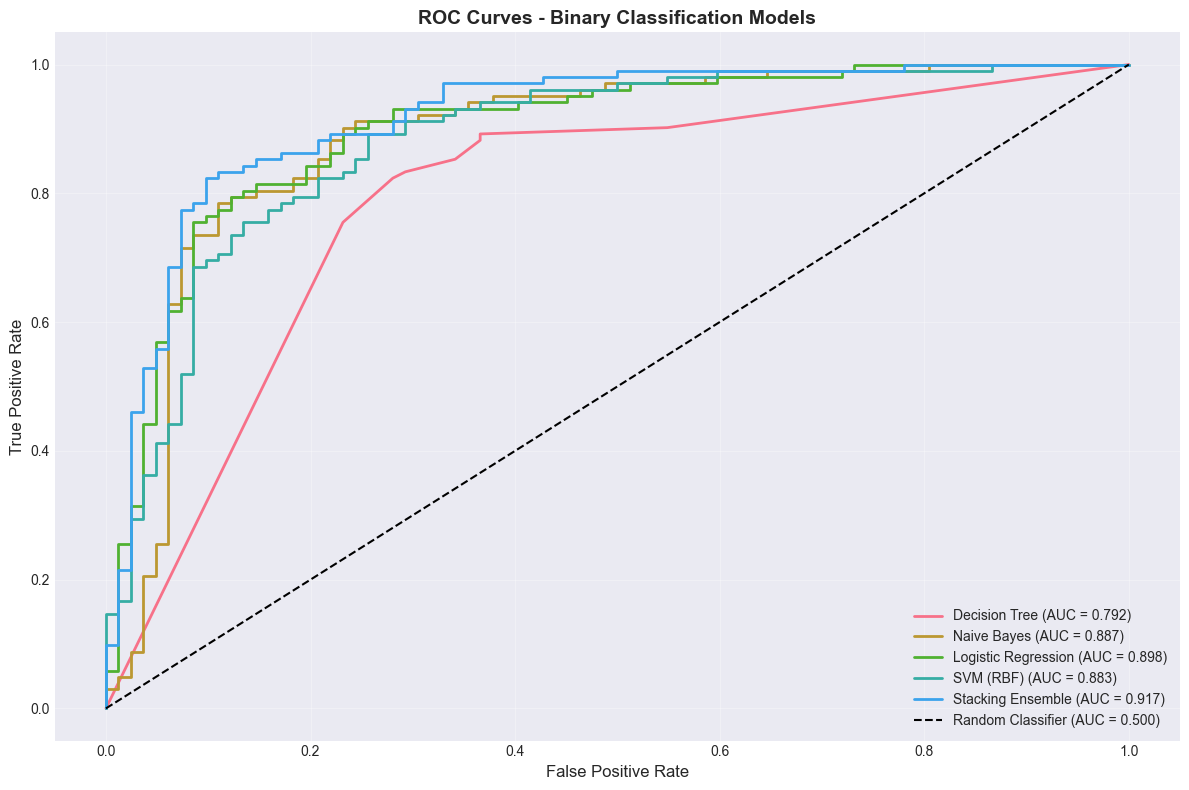

In [22]:
# Plot ROC curves for all binary classification models
plt.figure(figsize=(12, 8))

for name, result in binary_results.items():
    model = result['model']
    # Get probability predictions
    try:
        if hasattr(model, 'predict_proba'):
            y_proba = model.predict_proba(X_test_bin_scaled)[:, 1]
        elif hasattr(model, 'predict'):
            # For neural networks, get probability directly
            if 'Neural Network' in name:
                y_proba = model.predict(X_test_bin_scaled, verbose=0).flatten()
            else:
                continue
        else:
            continue
        
        fpr, tpr, _ = roc_curve(y_test_bin, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.3f})', linewidth=2)
    except Exception as e:
        print(f"Could not generate ROC for {name}: {e}")
        continue

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.500)', linewidth=1.5)
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves - Binary Classification Models', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('roc_curves_binary_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Binary Classification - Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.858696   0.858696 0.858696  0.858696
         Linear SVM  0.826087   0.825877 0.826087  0.825585
Deep Neural Network  0.831522   0.831272 0.831522  0.831173

Best Binary Classification Model: Random Forest


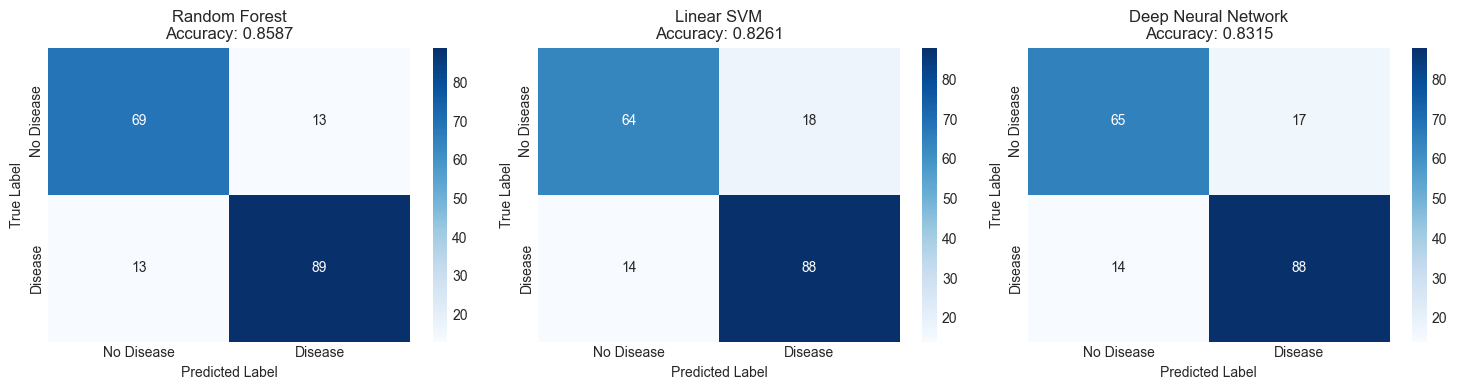

In [23]:
# Compare binary classification models
results_binary = {
    'Model': ['Random Forest', 'Linear SVM', 'Deep Neural Network'],
    'Accuracy': [acc_rf_bin, acc_svm_bin, acc_dnn_bin],
    'Precision': [prec_rf_bin, prec_svm_bin, prec_dnn_bin],
    'Recall': [rec_rf_bin, rec_svm_bin, rec_dnn_bin],
    'F1-Score': [f1_rf_bin, f1_svm_bin, f1_dnn_bin]
}

df_results_bin = pd.DataFrame(results_binary)
print("Binary Classification - Model Comparison:")
print(df_results_bin.to_string(index=False))

# Find best model
best_binary_model = df_results_bin.loc[df_results_bin['Accuracy'].idxmax(), 'Model']
print(f"\nBest Binary Classification Model: {best_binary_model}")

# Plot confusion matrix for best binary model
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

models_bin = {
    'Random Forest': (y_pred_rf_bin, rf_binary),
    'Linear SVM': (y_pred_svm_bin, svm_binary),
    'Deep Neural Network': (y_pred_dnn_bin, dnn_binary)
}

for idx, (name, (y_pred, model)) in enumerate(models_bin.items()):
    cm = confusion_matrix(y_test_bin, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                xticklabels=['No Disease', 'Disease'],
                yticklabels=['No Disease', 'Disease'])
    axes[idx].set_title(f'{name}\nAccuracy: {accuracy_score(y_test_bin, y_pred):.4f}')
    axes[idx].set_ylabel('True Label')
    axes[idx].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Save best binary model predictions for later use
if best_binary_model == 'Random Forest':
    best_binary_pred = y_pred_rf_bin
    best_binary_model_obj = rf_binary
elif best_binary_model == 'Linear SVM':
    best_binary_pred = y_pred_svm_bin
    best_binary_model_obj = svm_binary
else:
    best_binary_pred = y_pred_dnn_bin
    best_binary_model_obj = dnn_binary

# Store results in dictionary for easier access
binary_results = {
    'Random Forest': {
        'accuracy': acc_rf_bin,
        'precision': prec_rf_bin,
        'recall': rec_rf_bin,
        'f1': f1_rf_bin,
        'predictions': y_pred_rf_bin,
        'model': rf_binary
    },
    'Linear SVM': {
        'accuracy': acc_svm_bin,
        'precision': prec_svm_bin,
        'recall': rec_svm_bin,
        'f1': f1_svm_bin,
        'predictions': y_pred_svm_bin,
        'model': svm_binary
    },
    'Deep Neural Network': {
        'accuracy': acc_dnn_bin,
        'precision': prec_dnn_bin,
        'recall': rec_dnn_bin,
        'f1': f1_dnn_bin,
        'predictions': y_pred_dnn_bin,
        'model': dnn_binary
    }
}


### 2.4 Sub-Task 1.2: Multi-class Classification

Use original labels (0, 1, 2, 3, 4) for severity levels


In [24]:
# Use original multi-class labels
y_multiclass = y.copy()

# Split data for multi-class classification
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X_encoded, y_multiclass, test_size=0.2, random_state=42, stratify=y_multiclass
)

print("Multi-class classification - Training set size:", X_train_multi.shape)
print("Multi-class classification - Test set size:", X_test_multi.shape)
print("Multi-class label distribution in training set:")
print(pd.Series(y_train_multi).value_counts().sort_index())


Multi-class classification - Training set size: (736, 14)
Multi-class classification - Test set size: (184, 14)
Multi-class label distribution in training set:
level
0    329
1    212
2     87
3     86
4     22
Name: count, dtype: int64


#### 2.4.1 Random Forest Classifier (Multi-class)


In [25]:
# Train Random Forest for multi-class classification
rf_multi = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_multi.fit(X_train_multi, y_train_multi)

# Predictions
y_pred_rf_multi = rf_multi.predict(X_test_multi)

# Evaluation metrics
acc_rf_multi = accuracy_score(y_test_multi, y_pred_rf_multi)
prec_rf_multi = precision_score(y_test_multi, y_pred_rf_multi, average='weighted')
rec_rf_multi = recall_score(y_test_multi, y_pred_rf_multi, average='weighted')
f1_rf_multi = f1_score(y_test_multi, y_pred_rf_multi, average='weighted')

print("Random Forest (Multi-class Classification) Results:")
print(f"Accuracy: {acc_rf_multi:.4f}")
print(f"Precision: {prec_rf_multi:.4f}")
print(f"Recall: {rec_rf_multi:.4f}")
print(f"F1-Score: {f1_rf_multi:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_rf_multi, 
                          target_names=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4']))


Random Forest (Multi-class Classification) Results:
Accuracy: 0.6196
Precision: 0.5757
Recall: 0.6196
F1-Score: 0.5943

Classification Report:
              precision    recall  f1-score   support

     Level 0       0.80      0.88      0.84        82
     Level 1       0.53      0.62      0.57        53
     Level 2       0.29      0.18      0.22        22
     Level 3       0.28      0.24      0.26        21
     Level 4       0.00      0.00      0.00         6

    accuracy                           0.62       184
   macro avg       0.38      0.38      0.38       184
weighted avg       0.58      0.62      0.59       184



#### 2.4.2 Deep Neural Network (Multi-class)


In [26]:
# Build Deep Neural Network for multi-class classification
def create_multiclass_dnn(input_dim, num_classes):
    model = keras.Sequential([
        layers.Dense(128, activation='relu', input_shape=(input_dim,)),
        layers.Dropout(0.3),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        # Output layer with float32 dtype for proper loss calculation (if using mixed precision)
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create and train DNN
# Ensure we have the correct number of classes (0-4 = 5 classes)
num_classes = int(y_multiclass.max() - y_multiclass.min() + 1)
dnn_multi = create_multiclass_dnn(X_train_multi.shape[1], num_classes)
print("DNN Architecture:")
dnn_multi.summary()

# Train the model
history_dnn_multi = dnn_multi.fit(
    X_train_multi, y_train_multi,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)

# Predictions
y_pred_dnn_multi = np.argmax(dnn_multi.predict(X_test_multi), axis=1)

# Evaluation metrics
acc_dnn_multi = accuracy_score(y_test_multi, y_pred_dnn_multi)
prec_dnn_multi = precision_score(y_test_multi, y_pred_dnn_multi, average='weighted')
rec_dnn_multi = recall_score(y_test_multi, y_pred_dnn_multi, average='weighted')
f1_dnn_multi = f1_score(y_test_multi, y_pred_dnn_multi, average='weighted')

print("\nDeep Neural Network (Multi-class Classification) Results:")
print(f"Accuracy: {acc_dnn_multi:.4f}")
print(f"Precision: {prec_dnn_multi:.4f}")
print(f"Recall: {rec_dnn_multi:.4f}")
print(f"F1-Score: {f1_dnn_multi:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_multi, y_pred_dnn_multi,
                          target_names=['Level 0', 'Level 1', 'Level 2', 'Level 3', 'Level 4']))


DNN Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │         1,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,421 (48.52 KB)

 Trainable params: 12,421 (48.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4099 - loss: 1.5233 - val_accuracy: 0.4324 - val_loss: 1.3688
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4660 - loss: 1.2943 - val_accuracy: 0.4459 - val_loss: 1.2779
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.4745 - loss: 1.2305 - val_accuracy: 0.5068 - val_loss: 1.1996
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5255 - loss: 1.1566 - val_accuracy: 0.5068 - val_loss: 1.1481
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5646 - loss: 1.1052 - val_accuracy: 0.5135 - val_loss: 1.1196
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5765 - loss: 1.0567 - val_accuracy: 0.5068 - val_loss: 1.1121
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5663 - loss: 1.0637 - val_accuracy: 0.5203 - val_loss: 1.1000
Epoch 8/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5714 - loss: 1.0253 - val_accuracy: 0.5135 - val_loss

#### 2.4.3 Multi-class Classification Comparison and Visualization


Multi-class Classification - Model Comparison:
              Model  Accuracy  Precision   Recall  F1-Score
      Random Forest  0.619565   0.575700 0.619565  0.594250
Deep Neural Network  0.592391   0.556126 0.592391  0.571728

Best Multi-class Classification Model: Random Forest


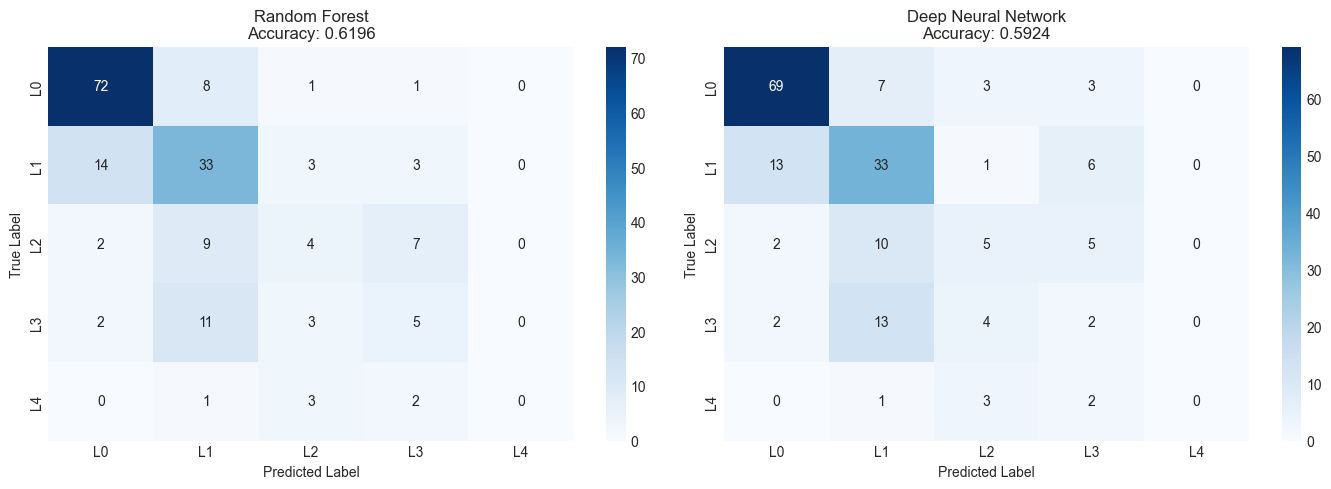

In [27]:
# Compare multi-class classification models
results_multiclass = {
    'Model': ['Random Forest', 'Deep Neural Network'],
    'Accuracy': [acc_rf_multi, acc_dnn_multi],
    'Precision': [prec_rf_multi, prec_dnn_multi],
    'Recall': [rec_rf_multi, rec_dnn_multi],
    'F1-Score': [f1_rf_multi, f1_dnn_multi]
}

df_results_multi = pd.DataFrame(results_multiclass)
print("Multi-class Classification - Model Comparison:")
print(df_results_multi.to_string(index=False))

# Find best model
best_multi_model = df_results_multi.loc[df_results_multi['Accuracy'].idxmax(), 'Model']
print(f"\nBest Multi-class Classification Model: {best_multi_model}")

# Plot confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Random Forest confusion matrix
cm_rf = confusion_matrix(y_test_multi, y_pred_rf_multi)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=['L0', 'L1', 'L2', 'L3', 'L4'],
            yticklabels=['L0', 'L1', 'L2', 'L3', 'L4'])
axes[0].set_title(f'Random Forest\nAccuracy: {acc_rf_multi:.4f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# DNN confusion matrix
cm_dnn = confusion_matrix(y_test_multi, y_pred_dnn_multi)
sns.heatmap(cm_dnn, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=['L0', 'L1', 'L2', 'L3', 'L4'],
            yticklabels=['L0', 'L1', 'L2', 'L3', 'L4'])
axes[1].set_title(f'Deep Neural Network\nAccuracy: {acc_dnn_multi:.4f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.show()

# Save best multi-class model
if best_multi_model == 'Random Forest':
    best_multi_pred = y_pred_rf_multi
    best_multi_model_obj = rf_multi
else:
    best_multi_pred = y_pred_dnn_multi
    best_multi_model_obj = dnn_multi

# Store initial results
multiclass_results = {
    'Random Forest': {
        'accuracy': acc_rf_multi,
        'precision': prec_rf_multi,
        'recall': rec_rf_multi,
        'f1': f1_rf_multi,
        'predictions': y_pred_rf_multi,
        'model': rf_multi
    },
    'Deep Neural Network': {
        'accuracy': acc_dnn_multi,
        'precision': prec_dnn_multi,
        'recall': rec_dnn_multi,
        'f1': f1_dnn_multi,
        'predictions': y_pred_dnn_multi,
        'model': dnn_multi
    }
}


#### 2.4.4 Multiclass Classification Improvements (SMOTE, Class Weights, Ensemble)


In [28]:
# Scale data for multiclass models
scaler_multi = StandardScaler()
X_train_multi_scaled = scaler_multi.fit_transform(X_train_multi)
X_test_multi_scaled = scaler_multi.transform(X_test_multi)

# Calculate class weights
print("Calculating class weights...")
class_weights_multi = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_multi),
    y=y_train_multi
)
class_weight_dict_multi = dict(enumerate(class_weights_multi))
print("Class weights:", class_weight_dict_multi)

# Apply SMOTE to training data ONLY (to handle class imbalance)
print("\nApplying SMOTE to training data...")
print("Before SMOTE:", np.bincount(y_train_multi))

# Check if SMOTE is available
if SMOTE_AVAILABLE:
    # SMOTE requires at least 2 samples per class, adjust k_neighbors for small classes
    min_class_count = np.min(np.bincount(y_train_multi))
    k_neighbors = min(3, min_class_count - 1) if min_class_count > 1 else 1
    
    try:
        smote = SMOTE(random_state=42, k_neighbors=k_neighbors)
        X_train_multi_balanced, y_train_multi_balanced = smote.fit_resample(
            X_train_multi_scaled, y_train_multi
        )
        print("After SMOTE:", np.bincount(y_train_multi_balanced))
        print(f"Training set size increased from {len(X_train_multi)} to {len(X_train_multi_balanced)}")
    except Exception as e:
        print(f"SMOTE failed: {e}. Using original data with class weights.")
        X_train_multi_balanced = X_train_multi_scaled
        y_train_multi_balanced = y_train_multi
else:
    print("SMOTE not available. Using original data with class weights.")
    print("To enable SMOTE, install: pip install imbalanced-learn")
    X_train_multi_balanced = X_train_multi_scaled
    y_train_multi_balanced = y_train_multi

print("\n" + "="*60)
print("TRAINING IMPROVED MULTICLASS MODELS")
print("="*60)


Calculating class weights...
Class weights: {0: np.float64(0.4474164133738602), 1: np.float64(0.6943396226415094), 2: np.float64(1.6919540229885057), 3: np.float64(1.7116279069767442), 4: np.float64(6.6909090909090905)}

Applying SMOTE to training data...
Before SMOTE: [329 212  87  86  22]
SMOTE not available. Using original data with class weights.
To enable SMOTE, install: pip install imbalanced-learn

TRAINING IMPROVED MULTICLASS MODELS


In [29]:
# Improved Random Forest with class weights
print("\n1. Training Improved Random Forest...")
rf_multi_improved = RandomForestClassifier(
    n_estimators=300,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    class_weight='balanced',
    random_state=42
)
rf_multi_improved.fit(X_train_multi_balanced, y_train_multi_balanced)
y_pred_rf_multi_improved = rf_multi_improved.predict(X_test_multi_scaled)
acc_rf_multi_improved = accuracy_score(y_test_multi, y_pred_rf_multi_improved)
prec_rf_multi_improved = precision_score(y_test_multi, y_pred_rf_multi_improved, average='weighted')
rec_rf_multi_improved = recall_score(y_test_multi, y_pred_rf_multi_improved, average='weighted')
f1_rf_multi_improved = f1_score(y_test_multi, y_pred_rf_multi_improved, average='weighted')
multiclass_results['Random Forest (Improved)'] = {
    'accuracy': acc_rf_multi_improved,
    'precision': prec_rf_multi_improved,
    'recall': rec_rf_multi_improved,
    'f1': f1_rf_multi_improved,
    'predictions': y_pred_rf_multi_improved,
    'model': rf_multi_improved
}
print(f"   Accuracy: {acc_rf_multi_improved:.4f} (Improvement: +{(acc_rf_multi_improved - acc_rf_multi)*100:.2f}%)")

# SVM for multiclass
print("\n2. Training SVM (RBF)...")
svm_multi = SVC(kernel='rbf', C=10, probability=True, 
                class_weight='balanced', random_state=42)
svm_multi.fit(X_train_multi_balanced, y_train_multi_balanced)
y_pred_svm_multi = svm_multi.predict(X_test_multi_scaled)
acc_svm_multi = accuracy_score(y_test_multi, y_pred_svm_multi)
prec_svm_multi = precision_score(y_test_multi, y_pred_svm_multi, average='weighted')
rec_svm_multi = recall_score(y_test_multi, y_pred_svm_multi, average='weighted')
f1_svm_multi = f1_score(y_test_multi, y_pred_svm_multi, average='weighted')
multiclass_results['SVM (RBF)'] = {
    'accuracy': acc_svm_multi,
    'precision': prec_svm_multi,
    'recall': rec_svm_multi,
    'f1': f1_svm_multi,
    'predictions': y_pred_svm_multi,
    'model': svm_multi
}
print(f"   Accuracy: {acc_svm_multi:.4f}")

# Gradient Boosting
print("\n3. Training Gradient Boosting...")
gb_multi = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, 
                                      max_depth=5, random_state=42)
gb_multi.fit(X_train_multi_balanced, y_train_multi_balanced)
y_pred_gb_multi = gb_multi.predict(X_test_multi_scaled)
acc_gb_multi = accuracy_score(y_test_multi, y_pred_gb_multi)
prec_gb_multi = precision_score(y_test_multi, y_pred_gb_multi, average='weighted')
rec_gb_multi = recall_score(y_test_multi, y_pred_gb_multi, average='weighted')
f1_gb_multi = f1_score(y_test_multi, y_pred_gb_multi, average='weighted')
multiclass_results['Gradient Boosting'] = {
    'accuracy': acc_gb_multi,
    'precision': prec_gb_multi,
    'recall': rec_gb_multi,
    'f1': f1_gb_multi,
    'predictions': y_pred_gb_multi,
    'model': gb_multi
}
print(f"   Accuracy: {acc_gb_multi:.4f}")



1. Training Improved Random Forest...
   Accuracy: 0.6141 (Improvement: +-0.54%)

2. Training SVM (RBF)...
   Accuracy: 0.5489

3. Training Gradient Boosting...
   Accuracy: 0.5815


In [30]:
# Improved DNN with class weights
print("\n4. Training Improved Deep Neural Network...")
def create_improved_multiclass_dnn(input_dim, num_classes):
    model = keras.Sequential([
        layers.Dense(256, activation='relu', 
                     input_shape=(input_dim,),
                     kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(128, activation='relu', 
                     kernel_regularizer=keras.regularizers.l2(0.001)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(64, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(num_classes, activation='softmax', dtype='float32')
    ])
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

dnn_multi_improved = create_improved_multiclass_dnn(X_train_multi_scaled.shape[1], num_classes)

# Convert class weights to sample weights for DNN
sample_weights = np.array([class_weight_dict_multi[y] for y in y_train_multi_balanced])

history_dnn_multi_improved = dnn_multi_improved.fit(
    X_train_multi_balanced, y_train_multi_balanced,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    sample_weight=sample_weights,
    callbacks=[EarlyStopping(patience=20, restore_best_weights=True, monitor='val_loss')],
    verbose=0
)

y_pred_dnn_multi_improved = np.argmax(dnn_multi_improved.predict(X_test_multi_scaled, verbose=0), axis=1)
acc_dnn_multi_improved = accuracy_score(y_test_multi, y_pred_dnn_multi_improved)
prec_dnn_multi_improved = precision_score(y_test_multi, y_pred_dnn_multi_improved, average='weighted')
rec_dnn_multi_improved = recall_score(y_test_multi, y_pred_dnn_multi_improved, average='weighted')
f1_dnn_multi_improved = f1_score(y_test_multi, y_pred_dnn_multi_improved, average='weighted')
multiclass_results['DNN (Improved)'] = {
    'accuracy': acc_dnn_multi_improved,
    'precision': prec_dnn_multi_improved,
    'recall': rec_dnn_multi_improved,
    'f1': f1_dnn_multi_improved,
    'predictions': y_pred_dnn_multi_improved,
    'model': dnn_multi_improved
}
print(f"   Accuracy: {acc_dnn_multi_improved:.4f} (Improvement: +{(acc_dnn_multi_improved - acc_dnn_multi)*100:.2f}%)")



4. Training Improved Deep Neural Network...
   Accuracy: 0.5598 (Improvement: +-3.26%)


In [31]:
# Create Ensemble Model
print("\n5. Creating Voting Ensemble...")
ensemble_multi = VotingClassifier(
    estimators=[
        ('rf', rf_multi_improved),
        ('svm', svm_multi),
        ('gb', gb_multi)
    ],
    voting='soft',
    weights=[3, 1, 2]  # Weight RF highest
)
ensemble_multi.fit(X_train_multi_balanced, y_train_multi_balanced)

y_pred_ensemble_multi = ensemble_multi.predict(X_test_multi_scaled)
acc_ensemble_multi = accuracy_score(y_test_multi, y_pred_ensemble_multi)
prec_ensemble_multi = precision_score(y_test_multi, y_pred_ensemble_multi, average='weighted')
rec_ensemble_multi = recall_score(y_test_multi, y_pred_ensemble_multi, average='weighted')
f1_ensemble_multi = f1_score(y_test_multi, y_pred_ensemble_multi, average='weighted')
multiclass_results['Ensemble (Voting)'] = {
    'accuracy': acc_ensemble_multi,
    'precision': prec_ensemble_multi,
    'recall': rec_ensemble_multi,
    'f1': f1_ensemble_multi,
    'predictions': y_pred_ensemble_multi,
    'model': ensemble_multi
}
print(f"   Accuracy: {acc_ensemble_multi:.4f} (Improvement: +{(acc_ensemble_multi - acc_rf_multi)*100:.2f}%)")

# Update best model if ensemble is better
if acc_ensemble_multi > acc_rf_multi:
    best_multi_model = 'Ensemble (Voting)'
    best_multi_pred = y_pred_ensemble_multi
    best_multi_model_obj = ensemble_multi
    print(f"\n✓ New best multiclass model: {best_multi_model}")

print("\n" + "="*80)
print("MULTICLASS CLASSIFICATION - COMPREHENSIVE RESULTS")
print("="*80)
results_table_multi = pd.DataFrame({
    'Model': list(multiclass_results.keys()),
    'Accuracy': [r['accuracy'] for r in multiclass_results.values()],
    'Precision': [r['precision'] for r in multiclass_results.values()],
    'Recall': [r['recall'] for r in multiclass_results.values()],
    'F1-Score': [r['f1'] for r in multiclass_results.values()]
}).sort_values('Accuracy', ascending=False)

print(results_table_multi.to_string(index=False))
print("\n" + "="*80)



5. Creating Voting Ensemble...
   Accuracy: 0.5924 (Improvement: +-2.72%)

MULTICLASS CLASSIFICATION - COMPREHENSIVE RESULTS
                   Model  Accuracy  Precision   Recall  F1-Score
           Random Forest  0.619565   0.575700 0.619565  0.594250
Random Forest (Improved)  0.614130   0.617144 0.614130  0.613118
     Deep Neural Network  0.592391   0.556126 0.592391  0.571728
       Ensemble (Voting)  0.592391   0.555437 0.592391  0.571532
       Gradient Boosting  0.581522   0.545789 0.581522  0.560301
          DNN (Improved)  0.559783   0.566742 0.559783  0.554588
               SVM (RBF)  0.548913   0.552494 0.548913  0.549814



## 3. Task 2: Heart Disease Detection (X-Ray Images)

### 3.1 Data Loading and Preprocessing


In [32]:
# Define heart-related and non-heart-related disease classes
heart_related = [
    'atherosclerosis_of_the_aorta',
    'cardiomegaly',
    'pneumonia',
    'pneumosclerosis',
    'post_inflammatory_changes',
    'post_traumatic_ribs_deformation'
]

non_heart_related = [
    'abscess',
    'ards',
    'atelectasis',
    'emphysema',
    'fracture',
    'hydropneumothorax',
    'hydrothorax',
    'sarcoidosis',
    'scoliosis',
    'tuberculosis',
    'venous_congestion'
]

# Function to load images from folders
def load_images_from_folders(base_path, target_size=(128, 128)):
    images = []
    labels = []
    
    # Process heart-related classes (label = 1)
    for folder in heart_related:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg'):
                    img_path = os.path.join(folder_path, filename)
                    try:
                        img = Image.open(img_path).convert('L')  # Convert to grayscale
                        img = img.resize(target_size)
                        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                        images.append(img_array)
                        labels.append(1)  # Heart-related
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    
    # Process non-heart-related classes (label = 0)
    for folder in non_heart_related:
        folder_path = os.path.join(base_path, folder)
        if os.path.exists(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith('.jpg'):
                    img_path = os.path.join(folder_path, filename)
                    try:
                        img = Image.open(img_path).convert('L')  # Convert to grayscale
                        img = img.resize(target_size)
                        img_array = np.array(img) / 255.0  # Normalize to [0, 1]
                        images.append(img_array)
                        labels.append(0)  # Non-heart-related
                    except Exception as e:
                        print(f"Error loading {img_path}: {e}")
    
    return np.array(images), np.array(labels)

# Load images
base_path = 'Dataset2/files'
print("Loading images...")
X_images, y_images = load_images_from_folders(base_path)

# Reshape for CNN (add channel dimension)
X_images = X_images.reshape(-1, 128, 128, 1)

print(f"\nLoaded {len(X_images)} images")
print(f"Image shape: {X_images.shape}")
print(f"Label distribution:")
print(f"  Heart-related (1): {np.sum(y_images == 1)}")
print(f"  Non-heart-related (0): {np.sum(y_images == 0)}")


Loading images...

Loaded 97 images
Image shape: (97, 128, 128, 1)
Label distribution:
  Heart-related (1): 35
  Non-heart-related (0): 62


### 3.2 Train-Test Split


In [33]:
# Split the image data
X_train_img, X_test_img, y_train_img, y_test_img = train_test_split(
    X_images, y_images, test_size=0.2, random_state=42, stratify=y_images
)

print(f"Training set: {X_train_img.shape[0]} images")
print(f"Test set: {X_test_img.shape[0]} images")
print(f"\nTraining label distribution:")
print(f"  Heart-related (1): {np.sum(y_train_img == 1)}")
print(f"  Non-heart-related (0): {np.sum(y_train_img == 0)}")


Training set: 77 images
Test set: 20 images

Training label distribution:
  Heart-related (1): 28
  Non-heart-related (0): 49


### 3.3 Convolutional Neural Network (CNN) Model


In [34]:
# Build CNN from scratch
def create_cnn_model(input_shape):
    model = keras.Sequential([
        # First convolutional block
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second convolutional block
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third convolutional block
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Flatten and dense layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.3),
        # Output layer with float32 dtype for proper loss calculation (if using mixed precision)
        layers.Dense(1, activation='sigmoid', dtype='float32')  # Binary classification
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Create the CNN model
cnn_model = create_cnn_model((128, 128, 1))
print("CNN Architecture:")
cnn_model.summary()


CNN Architecture:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,312,385 (12.64 MB)

 Trainable params: 3,312,385 (12.64 MB)

 Non-trainable params: 0 (0.00 B)

### 3.4 Training the CNN Model


In [35]:
# Train the CNN model
history_cnn = cnn_model.fit(
    X_train_img, y_train_img,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 294ms/step - accuracy: 0.6066 - loss: 1.0810 - val_accuracy: 0.6250 - val_loss: 0.6714
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.5738 - loss: 0.7045 - val_accuracy: 0.2500 - val_loss: 0.6988
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.4918 - loss: 0.7762 - val_accuracy: 0.6250 - val_loss: 0.6910
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.5902 - loss: 0.6696 - val_accuracy: 0.6250 - val_loss: 0.6849
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.6230 - loss: 0.6861 - val_accuracy: 0.6250 - val_loss: 0.6767
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.6230 - loss: 0.6831 - val_accuracy: 0.6250 - val_loss: 0.6729
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.6393 - loss: 0.6605 - val_accuracy: 0.6250 - val_loss: 0.6724
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.6393 - loss: 0.6543 - val_accuracy: 0.6250 - val_loss:

### 3.5 Evaluation and Visualization


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
CNN (Image Classification) Results:
Global Accuracy: 0.7000
Precision: 0.6867
Recall: 0.7000
F1-Score: 0.6857

Classification Report:
                   precision    recall  f1-score   support

Non-Heart-Related       0.73      0.85      0.79        13
    Heart-Related       0.60      0.43      0.50         7

         accuracy                           0.70        20
        macro avg       0.67      0.64      0.64        20
     weighted avg       0.69      0.70      0.69        20



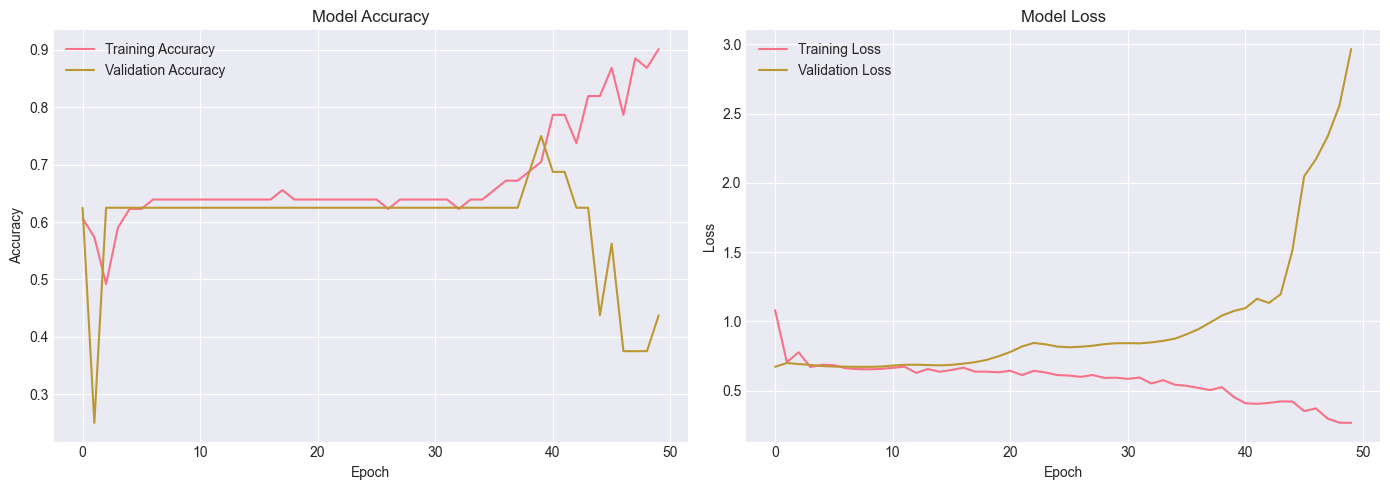

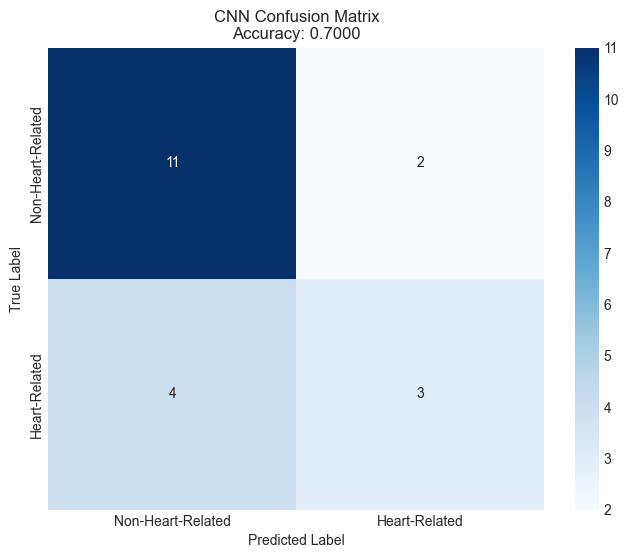

In [36]:
# Predictions
y_pred_cnn = (cnn_model.predict(X_test_img) > 0.5).astype(int).flatten()

# Evaluation metrics
acc_cnn = accuracy_score(y_test_img, y_pred_cnn)
prec_cnn = precision_score(y_test_img, y_pred_cnn, average='weighted')
rec_cnn = recall_score(y_test_img, y_pred_cnn, average='weighted')
f1_cnn = f1_score(y_test_img, y_pred_cnn, average='weighted')

print("CNN (Image Classification) Results:")
print(f"Global Accuracy: {acc_cnn:.4f}")
print(f"Precision: {prec_cnn:.4f}")
print(f"Recall: {rec_cnn:.4f}")
print(f"F1-Score: {f1_cnn:.4f}")
print("\nClassification Report:")
print(classification_report(y_test_img, y_pred_cnn, 
                          target_names=['Non-Heart-Related', 'Heart-Related']))

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy curve
axes[0].plot(history_cnn.history['accuracy'], label='Training Accuracy')
axes[0].plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss curve
axes[1].plot(history_cnn.history['loss'], label='Training Loss')
axes[1].plot(history_cnn.history['val_loss'], label='Validation Loss')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

# Confusion matrix
cm_cnn = confusion_matrix(y_test_img, y_pred_cnn)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Non-Heart-Related', 'Heart-Related'],
            yticklabels=['Non-Heart-Related', 'Heart-Related'])
plt.title(f'CNN Confusion Matrix\nAccuracy: {acc_cnn:.4f}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Store original CNN results
cnn_results = {
    'Basic CNN': {
        'accuracy': acc_cnn,
        'precision': prec_cnn,
        'recall': rec_cnn,
        'f1': f1_cnn,
        'predictions': y_pred_cnn,
        'model': cnn_model,
        'history': history_cnn
    }
}


## 4. Task 3: Image Reconstruction and Denoising (Autoencoder)

### 4.1 Noise Injection Function


In [37]:
# Function to add Gaussian noise to images
def add_gaussian_noise(images, mean=0, std=0.1):
    """
    Add Gaussian noise to images.
    Args:
        images: numpy array of images (normalized to [0, 1])
        mean: mean of the Gaussian noise
        std: standard deviation of the Gaussian noise
    Returns:
        Noisy images
    """
    noise = np.random.normal(mean, std, images.shape)
    noisy_images = images + noise
    # Clip values to [0, 1] range
    noisy_images = np.clip(noisy_images, 0, 1)
    return noisy_images

# Create noisy versions of training images
print("Creating noisy images...")
X_train_noisy = add_gaussian_noise(X_train_img, mean=0, std=0.15)
X_test_noisy = add_gaussian_noise(X_test_img, mean=0, std=0.15)

print(f"Noisy images created. Shape: {X_train_noisy.shape}")
print(f"Original pixel range: [{X_train_img.min():.3f}, {X_train_img.max():.3f}]")
print(f"Noisy pixel range: [{X_train_noisy.min():.3f}, {X_train_noisy.max():.3f}]")


Creating noisy images...
Noisy images created. Shape: (77, 128, 128, 1)
Original pixel range: [0.000, 1.000]
Noisy pixel range: [0.000, 1.000]


### 4.2 Convolutional Autoencoder Model


In [38]:
# Build Convolutional Autoencoder
def create_autoencoder(input_shape):
    # Encoder
    encoder_input = layers.Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(encoder_input)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    encoded = layers.MaxPooling2D((2, 2), padding='same')(x)
    
    # Decoder
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(encoded)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    
    decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
    
    autoencoder = keras.Model(encoder_input, decoded)
    autoencoder.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    return autoencoder

# Create autoencoder
autoencoder = create_autoencoder((128, 128, 1))
print("Autoencoder Architecture:")
autoencoder.summary()


Autoencoder Architecture:


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 128, 128, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 332,801 (1.27 MB)

 Trainable params: 332,801 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

### 4.3 Training the Autoencoder


In [39]:
# Train autoencoder: Input = Noisy Image, Target = Clean Original Image
history_ae = autoencoder.fit(
    X_train_noisy, X_train_img,  # Input: noisy, Target: clean
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    verbose=1
)


Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 518ms/step - loss: 0.0791 - mae: 0.2339 - val_loss: 0.0791 - val_mae: 0.2142
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - loss: 0.0668 - mae: 0.1970 - val_loss: 0.0735 - val_mae: 0.2259
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0657 - mae: 0.2066 - val_loss: 0.0652 - val_mae: 0.1970
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - loss: 0.0558 - mae: 0.1788 - val_loss: 0.0609 - val_mae: 0.1977
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - loss: 0.0521 - mae: 0.1739 - val_loss: 0.0523 - val_mae: 0.1617
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0443 - mae: 0.1589 - val_loss: 0.0408 - val_mae: 0.1367
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step - loss: 0.0337 - mae: 0.1293 - val_loss: 0.0313 - val_mae: 0.1293
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - loss: 0.0245 - mae: 0.1162 - val_loss: 0.0207 - val_mae: 0.1147
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - loss: 0.0203 - mae: 

### 4.4 Evaluation: RMSE Calculation


In [40]:
# Reconstruct images from noisy test set
X_test_reconstructed = autoencoder.predict(X_test_noisy)

# Calculate RMSE
def calculate_rmse(original, reconstructed):
    """Calculate Root Mean Square Error"""
    mse = np.mean((original - reconstructed) ** 2)
    rmse = np.sqrt(mse)
    return rmse

# Calculate absolute and relative RMSE
absolute_rmse = calculate_rmse(X_test_img, X_test_reconstructed)
relative_rmse = absolute_rmse / (X_test_img.max() - X_test_img.min())

print("Autoencoder Denoising Results:")
print(f"Absolute RMSE: {absolute_rmse:.6f}")
print(f"Relative RMSE: {relative_rmse:.6f}")

# Calculate per-image RMSE statistics
per_image_rmse = []
for i in range(len(X_test_img)):
    rmse = calculate_rmse(X_test_img[i], X_test_reconstructed[i])
    per_image_rmse.append(rmse)

print(f"\nPer-image RMSE Statistics:")
print(f"  Mean: {np.mean(per_image_rmse):.6f}")
print(f"  Std: {np.std(per_image_rmse):.6f}")
print(f"  Min: {np.min(per_image_rmse):.6f}")
print(f"  Max: {np.max(per_image_rmse):.6f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Autoencoder Denoising Results:
Absolute RMSE: 0.058985
Relative RMSE: 0.058985

Per-image RMSE Statistics:
  Mean: 0.056386
  Std: 0.017315
  Min: 0.036560
  Max: 0.097647


### 4.5 Visualization: Original vs Noisy vs Reconstructed


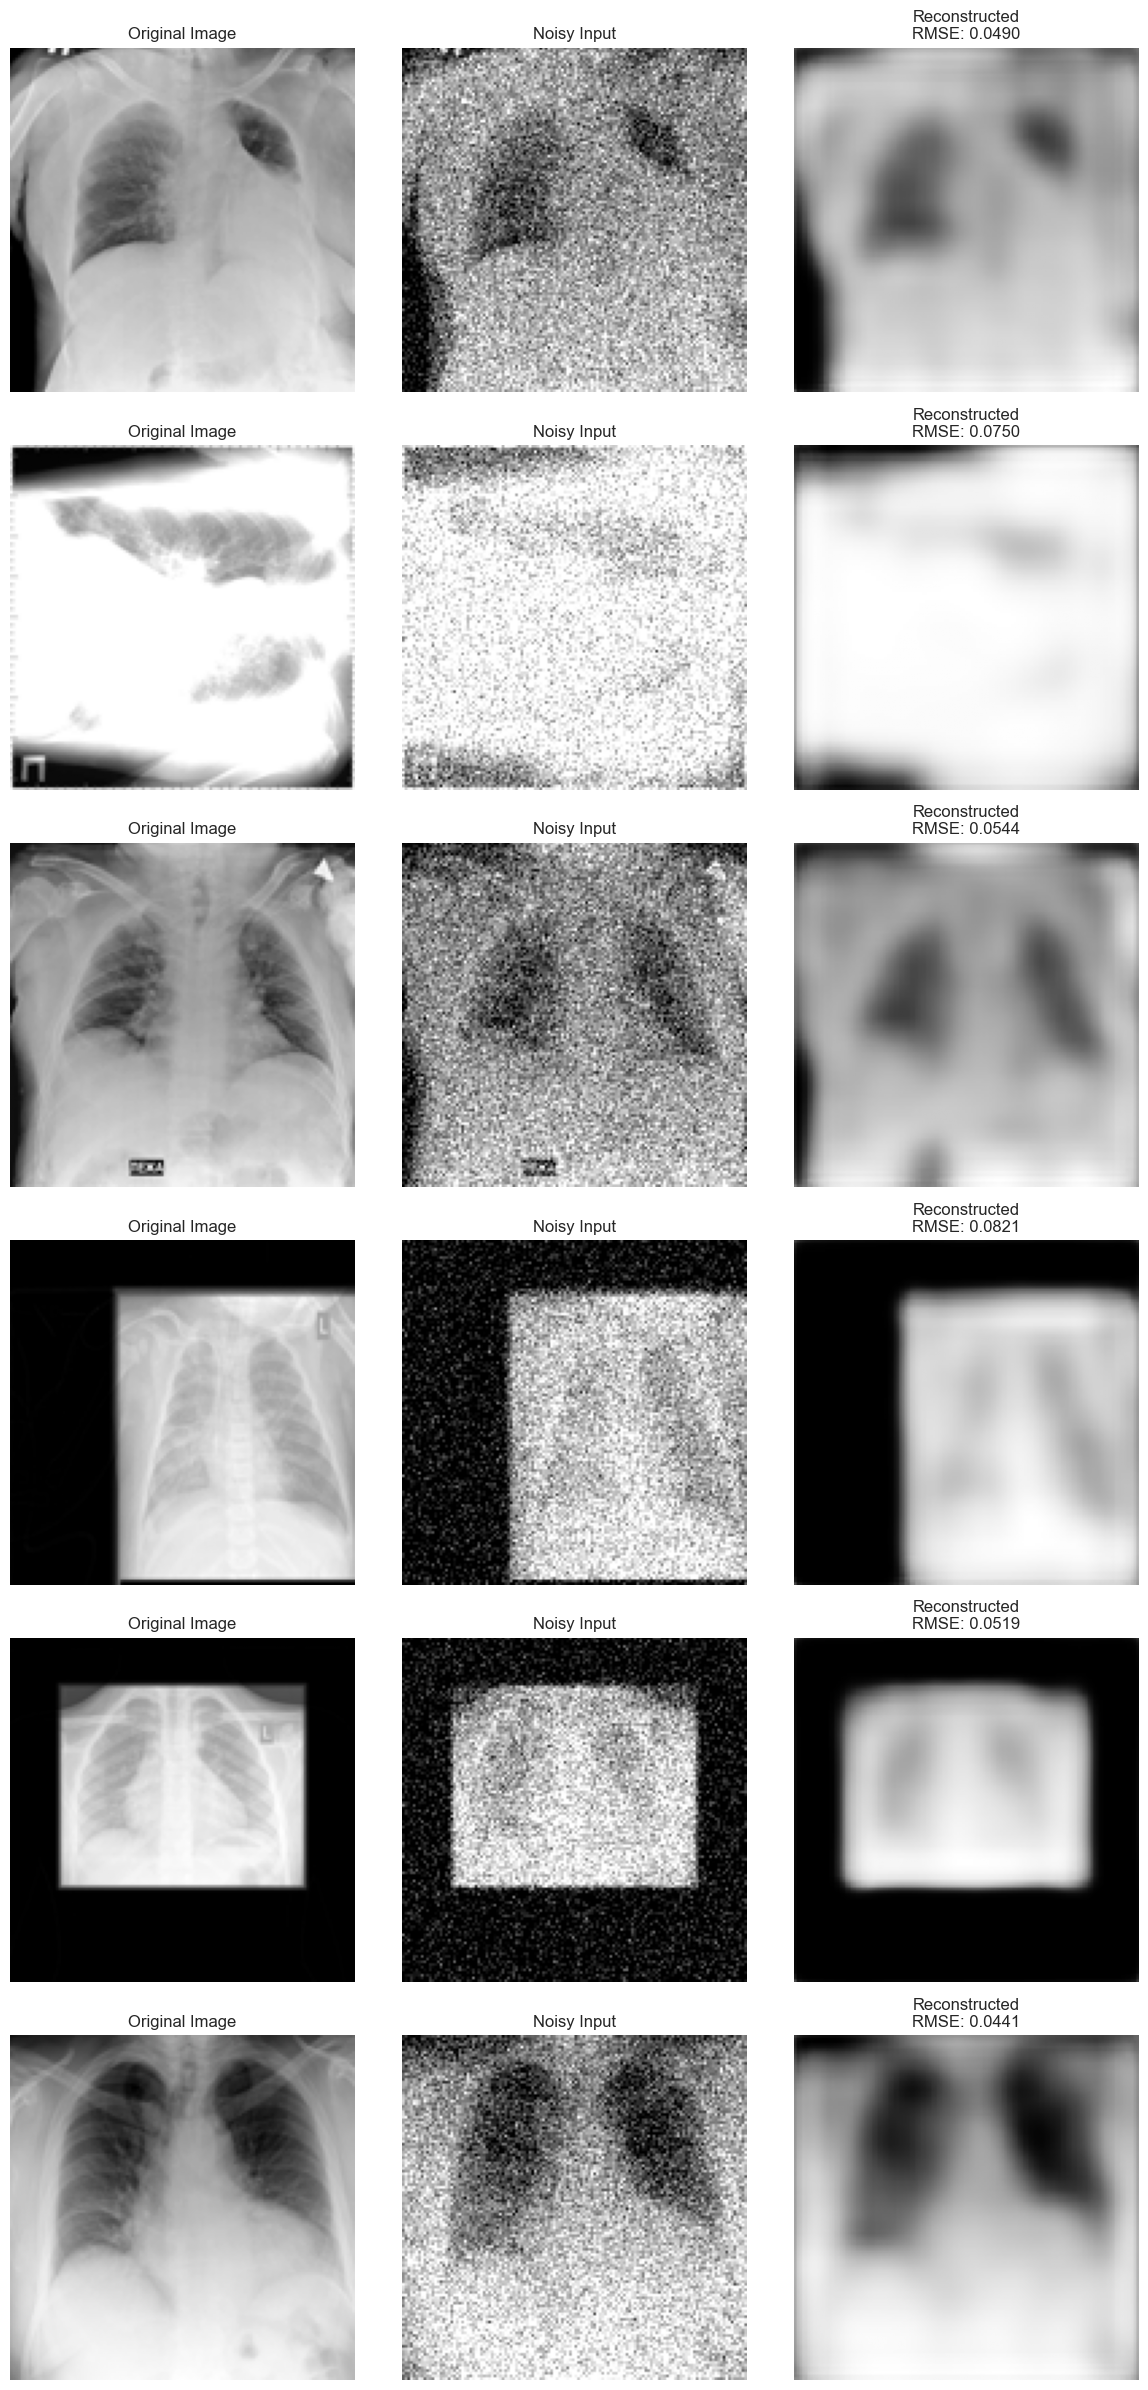

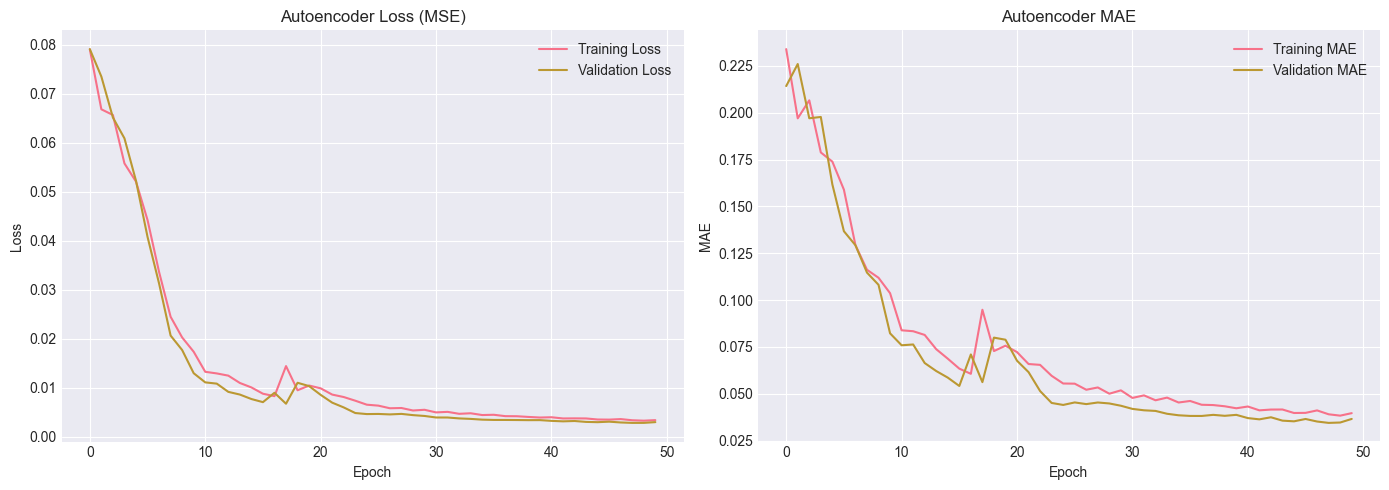

In [41]:
# Visualize results: Original | Noisy | Reconstructed
n_samples = 6
fig, axes = plt.subplots(n_samples, 3, figsize=(12, 4 * n_samples))

# Select random samples
indices = np.random.choice(len(X_test_img), n_samples, replace=False)

for i, idx in enumerate(indices):
    # Original image
    axes[i, 0].imshow(X_test_img[idx].squeeze(), cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')
    
    # Noisy image
    axes[i, 1].imshow(X_test_noisy[idx].squeeze(), cmap='gray')
    axes[i, 1].set_title('Noisy Input')
    axes[i, 1].axis('off')
    
    # Reconstructed image
    axes[i, 2].imshow(X_test_reconstructed[idx].squeeze(), cmap='gray')
    rmse_val = calculate_rmse(X_test_img[idx], X_test_reconstructed[idx])
    axes[i, 2].set_title(f'Reconstructed\nRMSE: {rmse_val:.4f}')
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

# Plot training curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
axes[0].plot(history_ae.history['loss'], label='Training Loss')
axes[0].plot(history_ae.history['val_loss'], label='Validation Loss')
axes[0].set_title('Autoencoder Loss (MSE)')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True)

# MAE curve
axes[1].plot(history_ae.history['mae'], label='Training MAE')
axes[1].plot(history_ae.history['val_mae'], label='Validation MAE')
axes[1].set_title('Autoencoder MAE')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('MAE')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()


## 5. Task 4: Integrated Diagnostic Interface

### 5.1 Diagnostic Function for Tabular Data


In [42]:
def diagnose_from_tabular(patient_data, model, scaler, label_encoders):
    """
    Diagnose heart disease from tabular patient data.
    
    Args:
        patient_data: Dictionary or pandas Series with patient features
        model: Trained binary classification model
        scaler: Fitted StandardScaler
        label_encoders: Dictionary of fitted LabelEncoders
    
    Returns:
        Dictionary with diagnosis results
    """
    # Convert to DataFrame if needed
    if isinstance(patient_data, dict):
        patient_df = pd.DataFrame([patient_data])
    else:
        patient_df = pd.DataFrame([patient_data])
    
    # Encode categorical variables
    patient_encoded = patient_df.copy()
    for col in categorical_cols:
        if col in patient_encoded.columns and col in label_encoders:
            # Fill NaN and convert to string
            patient_encoded[col] = patient_encoded[col].fillna('unknown').astype(str).replace('nan', 'unknown')
            try:
                patient_encoded[col] = label_encoders[col].transform(patient_encoded[col])
            except ValueError:
                # If value not seen during training, map to 'unknown' encoding
                # First, check if 'unknown' exists in the encoder
                try:
                    unknown_encoded = label_encoders[col].transform(['unknown'])[0]
                    patient_encoded[col] = patient_encoded[col].apply(
                        lambda x: unknown_encoded if x not in label_encoders[col].classes_ else label_encoders[col].transform([x])[0]
                    )
                except:
                    # Fallback: use the first encoded value (usually 0)
                    patient_encoded[col] = 0
    
    # Standardize numerical features
    patient_encoded[numerical_cols] = scaler.transform(patient_encoded[numerical_cols])
    
    # Make prediction
    if hasattr(model, 'predict_proba'):
        prob = model.predict_proba(patient_encoded)[0]
        prediction = model.predict(patient_encoded)[0]
    else:
        # For neural network
        prob = model.predict(patient_encoded, verbose=0)[0]
        prediction = (prob > 0.5).astype(int)[0]
        prob = [1 - prob[0], prob[0]]
    
    result = {
        'has_disease': bool(prediction),
        'probability': float(prob[1]) if len(prob) > 1 else float(prob[0]),
        'diagnosis': 'Heart disease detected' if prediction else 'No heart disease detected'
    }
    
    return result


### 5.2 Diagnostic Function for X-Ray Images


In [43]:
def diagnose_from_image(image_path, autoencoder_model, cnn_model, denoise=True):
    """
    Diagnose heart disease from X-ray image.
    
    Args:
        image_path: Path to the X-ray image file
        autoencoder_model: Trained autoencoder for denoising
        cnn_model: Trained CNN for classification
        denoise: Whether to apply denoising before classification
    
    Returns:
        Dictionary with diagnosis results
    """
    # Load and preprocess image
    try:
        img = Image.open(image_path).convert('L')
        img = img.resize((128, 128))
        img_array = np.array(img) / 255.0
        img_array = img_array.reshape(1, 128, 128, 1)
        
        # Denoise if requested
        if denoise:
            img_array = autoencoder_model.predict(img_array, verbose=0)
        
        # Classify
        prob = cnn_model.predict(img_array, verbose=0)[0][0]
        prediction = (prob > 0.5).astype(int)
        
        result = {
            'is_heart_related': bool(prediction),
            'probability': float(prob),
            'diagnosis': 'Heart-related disease detected' if prediction else 'Non-heart-related condition',
            'denoised': denoise
        }
        
        return result
    except Exception as e:
        return {'error': str(e)}


### 5.3 Integrated Diagnostic Interface


In [44]:
def diagnose_patient(tabular_data=None, image_path=None, 
                    tabular_model=None, autoencoder_model=None, cnn_model=None,
                    scaler=None, label_encoders=None, denoise=True):
    """
    Integrated diagnostic interface that can process both tabular data and/or X-ray images.
    
    Args:
        tabular_data: Dictionary or pandas Series with patient features (optional)
        image_path: Path to X-ray image file (optional)
        tabular_model: Trained binary classification model for tabular data
        autoencoder_model: Trained autoencoder for image denoising
        cnn_model: Trained CNN for image classification
        scaler: Fitted StandardScaler for tabular data
        label_encoders: Dictionary of fitted LabelEncoders for tabular data
        denoise: Whether to denoise images before classification
    
    Returns:
        Dictionary with combined diagnosis results
    """
    results = {}
    
    # Process tabular data if provided
    if tabular_data is not None and tabular_model is not None:
        tabular_result = diagnose_from_tabular(
            tabular_data, tabular_model, scaler, label_encoders
        )
        results['tabular_diagnosis'] = tabular_result
    
    # Process image if provided
    if image_path is not None and cnn_model is not None:
        image_result = diagnose_from_image(
            image_path, autoencoder_model, cnn_model, denoise=denoise
        )
        results['image_diagnosis'] = image_result
    
    # Combine results if both are available
    if 'tabular_diagnosis' in results and 'image_diagnosis' in results:
        results['combined_decision'] = {
            'both_positive': (results['tabular_diagnosis']['has_disease'] and 
                           results['image_diagnosis']['is_heart_related']),
            'recommendation': 'Further medical consultation recommended' if (
                results['tabular_diagnosis']['has_disease'] or 
                results['image_diagnosis']['is_heart_related']
            ) else 'No immediate concerns detected'
        }
    
    return results

# Example usage demonstration
print("=== Integrated Diagnostic Interface ===\n")

# Example 1: Tabular data diagnosis
print("Example 1: Diagnosing from Tabular Data")
sample_patient = {
    'age': 55,
    'sex': 'Male',
    'Origin': 'Cleveland',
    'cp': 'atypical angina',
    'trestbps': 130,
    'chol': 250,
    'fbs': False,
    'restecg': 'normal',
    'thalch': 150,
    'exang': False,
    'oldpeak': 1.5,
    'slope': 'upsloping',
    'ca': 0,
    'thal': 'normal'
}

tabular_result = diagnose_patient(
    tabular_data=sample_patient,
    tabular_model=best_binary_model_obj,
    scaler=scaler,
    label_encoders=label_encoders
)
print("Tabular Diagnosis Result:")
print(f"  Diagnosis: {tabular_result['tabular_diagnosis']['diagnosis']}")
print(f"  Probability: {tabular_result['tabular_diagnosis']['probability']:.4f}")
print()

# Example 2: Image diagnosis (using a test image)
print("Example 2: Diagnosing from X-Ray Image")
# Use first test image as example
test_image_path = None
for folder in heart_related + non_heart_related:
    folder_path = os.path.join('Dataset2/files', folder)
    if os.path.exists(folder_path):
        for filename in os.listdir(folder_path):
            if filename.endswith('.jpg'):
                test_image_path = os.path.join(folder_path, filename)
                break
        if test_image_path:
            break

if test_image_path:
    image_result = diagnose_patient(
        image_path=test_image_path,
        autoencoder_model=autoencoder,
        cnn_model=cnn_model,
        denoise=True
    )
    print("Image Diagnosis Result:")
    print(f"  Diagnosis: {image_result['image_diagnosis']['diagnosis']}")
    print(f"  Probability: {image_result['image_diagnosis']['probability']:.4f}")
    print(f"  Denoised: {image_result['image_diagnosis']['denoised']}")
else:
    print("  No test image found for demonstration")

print("\n=== Interface Ready for Use ===")


=== Integrated Diagnostic Interface ===

Example 1: Diagnosing from Tabular Data
Tabular Diagnosis Result:
  Diagnosis: No heart disease detected
  Probability: 0.2732

Example 2: Diagnosing from X-Ray Image
Image Diagnosis Result:
  Diagnosis: Heart-related disease detected
  Probability: 0.7083
  Denoised: True

=== Interface Ready for Use ===
